# Obrada prirodnog jezika za razumijevanje povratnih informacija klijenata u ugostiteljskoj industriji

## Potrebni moduli

In [1]:
import re
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Učitavanje podataka

In [ ]:
# Za prikazivanje cijelih komentara
pd.set_option("max_colwidth", 100)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


## EDA

In [ ]:
# Vrijednosti koje nedostaju
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
df.Rating.describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

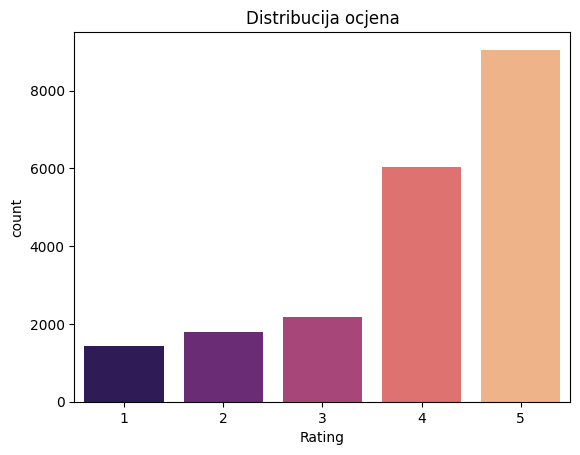

In [ ]:
# Distribucija ocjena
sns.countplot(data=df, x="Rating", palette="magma").set_title("Distribucija ocjena");

In [ ]:
# Duljina review-a (char)
df['Length'] = df['Review'].str.len()
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [ ]:
# Duljina review-a (riječ)
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word count'] = df['Review'].apply(word_count)
df.head()

,Review,Rating,Length,Word count
0,nice hotel expensive parking got good deal sta...,4,593,87
1,ok nothing special charge diamond member hilto...,2,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,600,89
4,"great stay great stay, went seahawk game aweso...",5,1281,191


In [ ]:
# Deskriptivna statistika
df.Length.describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Length, dtype: float64

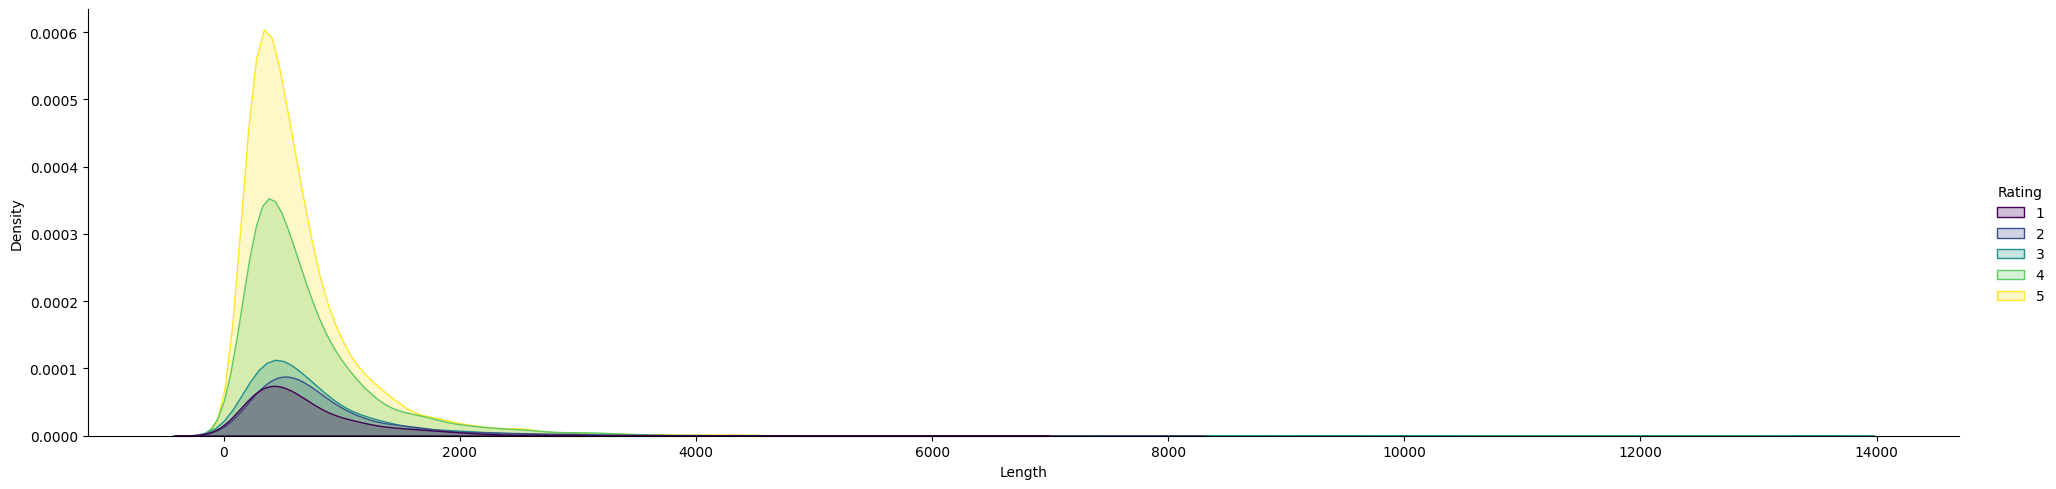

In [ ]:
sns.displot(data=df, x="Length", hue="Rating", palette="viridis", kind="kde", fill=True, aspect=4);

In [ ]:
df['Word count'].describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word count, dtype: float64

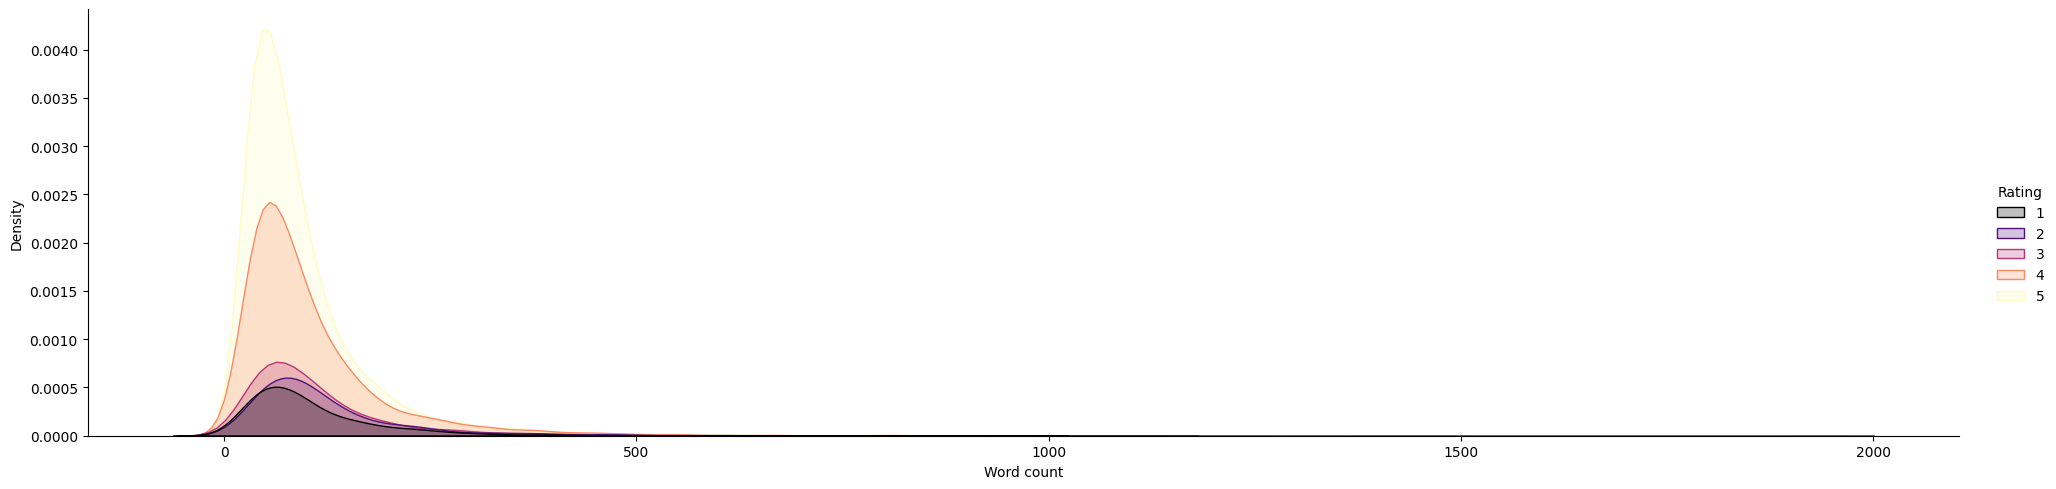

In [ ]:
sns.displot(data=df, x="Word count", hue="Rating", palette="magma", kind="kde", fill=True, aspect=4);

## Najzastupljenije riječi i *n*-grami

In [ ]:
df.drop(['Length', 'Word count'], axis = 1, inplace = True)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review) # uklanjanje specijalnih znakova
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [ ]:
df['Review'] = df['Review'].apply(clean)

In [ ]:
def split_into_words(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(split_into_words)

In [ ]:
df.head()

,Review,Rating,Review_lists
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms 4 experience hotel monaco seattle g...,3,"[nice, rooms, 4, experience, hotel, monaco, se..."
3,unique great stay wonderful time hotel monaco ...,5,"[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,5,"[great, stay, great, stay, went, seahawk, game..."


In [ ]:
corpus = [word for review_list in df['Review_lists'] for word in review_list]
len(corpus)

2060911

In [ ]:
most_common_words = Counter(corpus).most_common(10)
most_common_words

[('hotel', 48844),
 ('room', 34279),
 ('great', 21068),
 ('nt', 18989),
 ('good', 16953),
 ('staff', 16193),
 ('stay', 15142),
 ('nice', 12393),
 ('rooms', 12005),
 ('location', 11009)]

In [ ]:
words, freq = zip(*most_common_words)

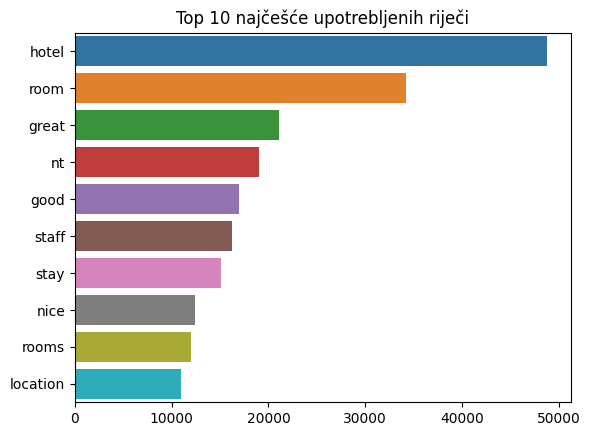

In [ ]:
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 10 najčešće upotrebljenih riječi')
plt.show()

In [ ]:
def display_ngram(n, df):
  cv = CountVectorizer(ngram_range=(n,n))
  n_gram = cv.fit_transform(df['Review'])
  count_values = n_gram.toarray().sum(axis=0)
  ngram_df = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
  ngram_df.columns = ["frequency", "ngram"]

  sns.barplot(x=ngram_df['frequency'][:10], y=ngram_df['ngram'][:10])
  plt.title('Top 10 najčešćih n-grama')
  plt.show()

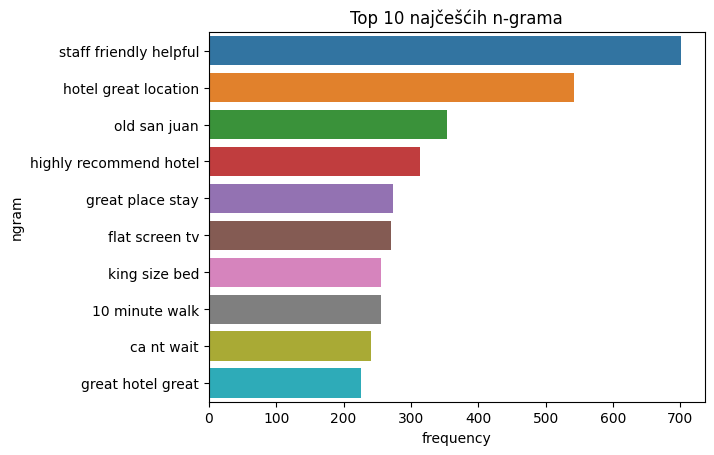

In [ ]:
n_gram = display_ngram(3, df)

## Analiza sentimenta sa sekvencijalnim modelima

// TODO
- ~~remove punctuation~~
- ~~GRU~~
- pre-trained embeddings
- BERT/RoBERTa

In [93]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Dense, Dropout, TextVectorization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from nltk.stem.snowball import SnowballStemmer

In [94]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [95]:
df['Label'] = df['Rating'].apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else 2))

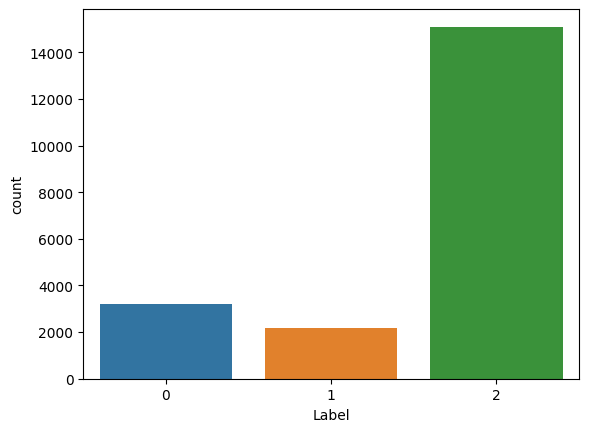

In [96]:
sns.countplot(x='Label', data=df);

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df["Review"], df["Label"], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [120]:
stemmer = SnowballStemmer("english")

def custom_preprocessing(text):
  # Removing punctuation
  text = re.sub(r'[^\w\s]', '', text)
  # Stemming
  text = " ".join(stemmer.stem(word) for word in text.split())

  return text

In [121]:
X_train = X_train.apply(custom_preprocessing)
X_val = X_val.apply(custom_preprocessing)
X_test = X_test.apply(custom_preprocessing)

In [122]:
batch_size = 32
VOCAB_TOKENS = 5000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_TOKENS)

encoder.adapt(train_ds.map(lambda text, labels: text))

np.array(encoder.get_vocabulary())[:20]

array(['', '[UNK]', 'hotel', 'room', 'not', 'stay', 'great', 'nt', 'good',
       'staff', 'night', 'did', 'locat', 'nice', 'day', 'time', 'just',
       'no', 'clean', 'servic'], dtype='<U14')

In [123]:
def plot_metrics(history):
    metrics = pd.DataFrame(history.history)
    metrics[['accuracy', 'val_accuracy']].plot()
    metrics[['loss', 'val_loss']].plot()

### *Vanilla* RNN

In [124]:
vanilla_rnn_model1 = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 100, mask_zero = True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')])

vanilla_rnn_model1.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = vanilla_rnn_model1.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = vanilla_rnn_model1.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 9s 71ms/step - loss: 0.4317 - accuracy: 0.8487
Test Loss: 0.431660532951355
Test Accuracy: 0.8487436175346375


### GRU

Epoch 1/20
385/385 [==============================] - 51s 117ms/step - loss: 1.0010 - accuracy: 0.7503 - val_loss: 0.6325 - val_accuracy: 0.8099
Epoch 2/20
385/385 [==============================] - 24s 62ms/step - loss: 0.6018 - accuracy: 0.8228 - val_loss: 0.5555 - val_accuracy: 0.8377
Epoch 3/20
385/385 [==============================] - 19s 50ms/step - loss: 0.5224 - accuracy: 0.8385 - val_loss: 0.5342 - val_accuracy: 0.8343
Epoch 4/20
385/385 [==============================] - 15s 39ms/step - loss: 0.4729 - accuracy: 0.8512 - val_loss: 0.6073 - val_accuracy: 0.8409
Epoch 5/20
385/385 [==============================] - 13s 34ms/step - loss: 0.4430 - accuracy: 0.8612 - val_loss: 0.5090 - val_accuracy: 0.8443
Epoch 6/20
385/385 [==============================] - 12s 32ms/step - loss: 0.3993 - accuracy: 0.8694 - val_loss: 0.5223 - val_accuracy: 0.8328
Epoch 7/20
385/385 [==============================] - 12s 31ms/step - loss: 0.3689 - accuracy: 0.8782 - val_loss: 0.5359 - val_accuracy

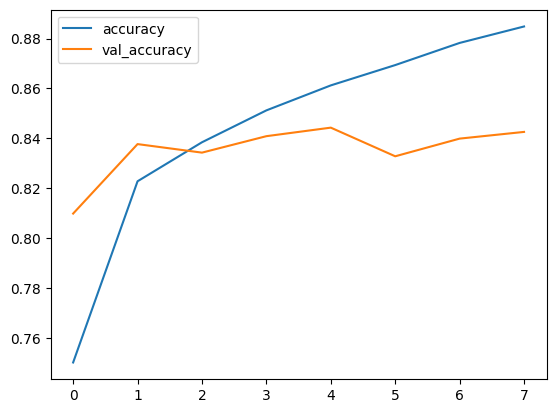

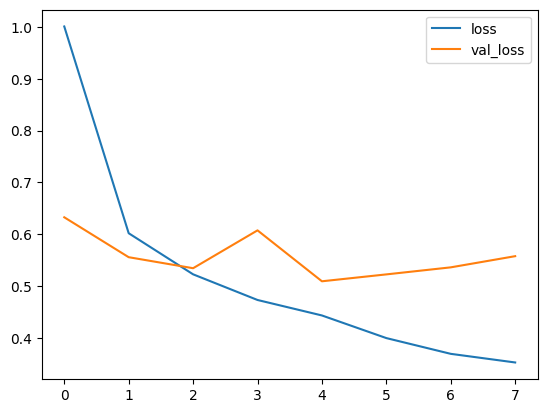

In [51]:
l1_reg = tf.keras.regularizers.l1(0.005)

gru_model2 = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 100, mask_zero = True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l1_reg),
    tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=l1_reg)])

gru_model2.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model2.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [52]:
test_loss, test_acc = gru_model2.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 13ms/step - loss: 0.6019 - accuracy: 0.8314
Test Loss: 0.601852297782898
Test Accuracy: 0.8314222693443298


## GRU sa predtreniranim vektorskim reprezentacijama riječi (Word2Vec)

In [53]:
import gensim.downloader as api

word2vec_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [112]:
vocab = encoder.get_vocabulary()
embedding_matrix = np.zeros((len(vocab), word2vec_model.vector_size))

for i, word in enumerate(vocab):
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(word2vec_model.vector_size, ))

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(vocab),
    output_dim=word2vec_model.vector_size,
    weights=[embedding_matrix],
    trainable=False
)

In [126]:
l1_reg = tf.keras.regularizers.l1(0.005)

gru_model17 = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l1_reg),
    tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=l1_reg)])

gru_model17.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = gru_model17.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_accuracy")]
)

plot_metrics(history)

Epoch 1/20
385/385 [==============================] - 12s 23ms/step - loss: 1.6311 - accuracy: 0.7049 - val_loss: 1.5212 - val_accuracy: 0.7350
Epoch 2/20
385/385 [==============================] - 9s 24ms/step - loss: 1.4932 - accuracy: 0.7317 - val_loss: 1.4284 - val_accuracy: 0.7408
Epoch 3/20
385/385 [==============================] - 9s 24ms/step - loss: 1.3991 - accuracy: 0.7348 - val_loss: 1.3348 - val_accuracy: 0.7418
Epoch 4/20
385/385 [==============================] - 8s 21ms/step - loss: 1.3103 - accuracy: 0.7363 - val_loss: 1.2478 - val_accuracy: 0.7423
Epoch 5/20
385/385 [==============================] - 8s 21ms/step - loss: 1.2250 - accuracy: 0.7366 - val_loss: 1.1730 - val_accuracy: 0.7426
Epoch 6/20
385/385 [==============================] - 9s 23ms/step - loss: 1.1483 - accuracy: 0.7370 - val_loss: 1.1013 - val_accuracy: 0.7428
Epoch 7/20
385/385 [==============================] - 10s 26ms/step - loss: 1.0844 - accuracy: 0.7370 - val_loss: 1.0424 - val_accuracy: 0.74

KeyboardInterrupt: 

## GloVe

In [127]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-01-08 22:17:42--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-08 22:17:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.03MB/s    in 2m 39s  

2024-01-08 22:20:22 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [128]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [129]:
glove_path = './glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

In [130]:
vocab = encoder.get_vocabulary()
embedding_dim = 100  # GloVe 6B model ima 100 dimenzija
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for i, word in enumerate(vocab):
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

In [1]:
# l1_reg = tf.keras.regularizers.l1(0.001)

gru_model_glove1 = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')])

gru_model_glove1.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model_glove1.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

NameError: name 'tf' is not defined